# Sushi & Sandwich Image Classification

In this notebook, i'd like to try make an image classification for sushi and sandwich images.

I use transfer & pre-trained model and choose the best possible model to deploy & implement for user.

# Import Libraries

In [1]:
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import pathlib
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import pandas as pd
import joblib
import os

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
dataset_folder = '/Users/siaaldo/Documents/Hacktiv8/P2M2/sushi_or_sandwich/'
sushi_folder = '/Users/siaaldo/Documents/Hacktiv8/P2M2/sushi_or_sandwich/sandwich/'
sandwich_folder = '/Users/siaaldo/Documents/Hacktiv8/P2M2/sushi_or_sandwich/sushi/'

dataset_data = pathlib.Path(dataset_folder)
sushi_data = pathlib.Path(sushi_folder)
sandwich_data = pathlib.Path(sandwich_folder)

In [3]:
sushi_images = list(sushi_data.glob('*/*')) #select all format variances
sandwich_images = list(sandwich_data.glob('*/*')) #select all format variances

print(f'Total Data Gambar {len(sushi_images)+len(sandwich_images)} gambar')
print(f'Jumlah data gambar sushi {len(sushi_images)} gambar')
print(f'Jumlah data gambar sandwich {len(sandwich_images)} gambar')

Total Data Gambar 804 gambar
Jumlah data gambar sushi 402 gambar
Jumlah data gambar sandwich 402 gambar


# Data Preprocessing

## Batch Size & Image Size

In [20]:
batch_size = 32

#image pixel for uniform size each image
IMG_SIZE = (200, 300)

## Train & Test Image Split

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_folder,
  validation_split=0.2,
  labels='inferred',
  label_mode='binary',
  subset="training",
  seed=25,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 804 files belonging to 2 classes.
Using 644 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_folder,
  validation_split=0.2,
  subset="validation",
  seed=25,
  image_size=IMG_SIZE,
  label_mode='binary',
  batch_size=batch_size
)

Found 804 files belonging to 2 classes.
Using 160 files for validation.


In [23]:
class_names = train_ds.class_names
print(class_names)

['sandwich', 'sushi']


## Enhance Model

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)

# Transfer Learning Using My Previous Model

## The Model

In [27]:
cnn_model = keras.models.load_model('cnn_model.h5')

## Remaking The Model

In [28]:
model_B_on_A = keras.models.Sequential(cnn_model.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [29]:
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer='adam',
                     metrics=["accuracy"])

## Model Training

In [30]:
history_mask_model = model_B_on_A.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               restore_best_weights=True)
)

Epoch 1/100
21/21 [==============================] - 4s 184ms/step - loss: 0.7391 - accuracy: 0.5435 - val_loss: 0.6741 - val_accuracy: 0.5562
Epoch 2/100
21/21 [==============================] - 4s 182ms/step - loss: 0.6462 - accuracy: 0.6382 - val_loss: 0.6723 - val_accuracy: 0.5813
Epoch 3/100
21/21 [==============================] - 4s 182ms/step - loss: 0.6085 - accuracy: 0.6630 - val_loss: 0.6594 - val_accuracy: 0.6438
Epoch 4/100
21/21 [==============================] - 4s 169ms/step - loss: 0.5458 - accuracy: 0.7112 - val_loss: 0.6761 - val_accuracy: 0.6562
Epoch 5/100
21/21 [==============================] - 4s 168ms/step - loss: 0.4587 - accuracy: 0.7950 - val_loss: 0.6789 - val_accuracy: 0.6562
Epoch 6/100
21/21 [==============================] - 4s 173ms/step - loss: 0.3712 - accuracy: 0.8416 - val_loss: 0.6984 - val_accuracy: 0.5938
Epoch 7/100
21/21 [==============================] - 4s 168ms/step - loss: 0.3360 - accuracy: 0.8773 - val_loss: 0.6554 - val_accuracy: 0.6062

## Model Evalutaion

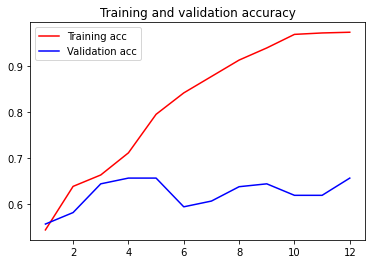

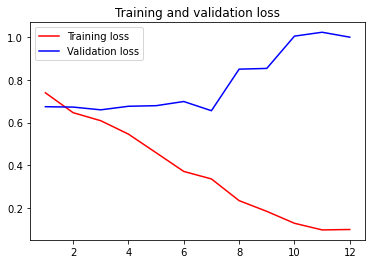

In [31]:
acc = history_mask_model.history['accuracy']
val_acc = history_mask_model.history['val_accuracy']
loss = history_mask_model.history['loss']
val_loss = history_mask_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

From the graphics above, the transfer learning from my previous model not realy performed in this problem. So i try to use Pre-trained model and see which one is the best model to deploy

# MOBILENET V2

## Preprocessing

In [63]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [64]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)

In [65]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [66]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 10, 1280)


In [67]:
base_model.trainable = False

In [68]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [69]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [70]:
prediction_layer = tf.keras.layers.Dense(1, 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

## Model Definition

In [71]:
inputs = tf.keras.Input(shape=(200, 300, 3))
x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model_mobv2 = tf.keras.Model(inputs, outputs)

In [72]:
base_learning_rate = 0.0001
model_mobv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [73]:
model_mobv2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 200, 300, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 200, 300, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 200, 300, 3)       0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 200, 300, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 10, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0   

In [74]:
print(f' Trainable Layers : {len(model_mobv2.trainable_variables)}')

 Trainable Layers : 2


In [49]:
initial_epochs = 10

loss0, accuracy0 = model_mobv2.evaluate(val_ds)

5/5 [==============================] - 2s 267ms/step - loss: 0.7916 - accuracy: 0.4563


In [75]:
history_mobv2 = model_mobv2.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, 
                                               restore_best_weights=True)
)

Epoch 1/10
21/21 [==============================] - 10s 408ms/step - loss: 0.8810 - accuracy: 0.4969 - val_loss: 0.7965 - val_accuracy: 0.4625
Epoch 2/10
21/21 [==============================] - 9s 408ms/step - loss: 0.7670 - accuracy: 0.5140 - val_loss: 0.7555 - val_accuracy: 0.4750
Epoch 3/10
21/21 [==============================] - 8s 393ms/step - loss: 0.7422 - accuracy: 0.5124 - val_loss: 0.7330 - val_accuracy: 0.4812
Epoch 4/10
21/21 [==============================] - 9s 400ms/step - loss: 0.7038 - accuracy: 0.5497 - val_loss: 0.7113 - val_accuracy: 0.4875
Epoch 5/10
21/21 [==============================] - 8s 379ms/step - loss: 0.7032 - accuracy: 0.5714 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 6/10
21/21 [==============================] - 9s 426ms/step - loss: 0.6787 - accuracy: 0.6009 - val_loss: 0.6714 - val_accuracy: 0.5437
Epoch 7/10
21/21 [==============================] - 10s 474ms/step - loss: 0.6647 - accuracy: 0.5963 - val_loss: 0.6534 - val_accuracy: 0.5500
Epoc

## Model Evalutaioin

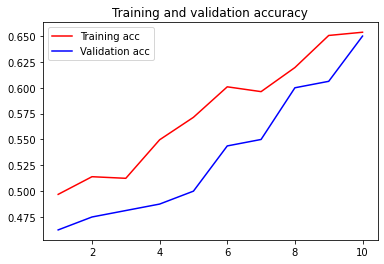

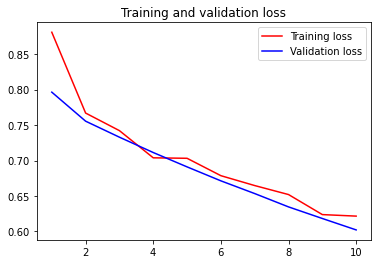

In [77]:
acc = history_mobv2.history['accuracy']
val_acc = history_mobv2.history['val_accuracy']
loss = history_mobv2.history['loss']
val_loss = history_mobv2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

# FINE TUNE MOBILENET V2

In [78]:
base_model.trainable = True

In [79]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

print(f' Trainable Fine Tuning Layers : {len(model_mobv2.trainable_variables)}')

Number of layers in the base model:  154
 Trainable Fine Tuning Layers : 56


In [80]:
model_mobv2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [81]:
model_mobv2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 200, 300, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 200, 300, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 200, 300, 3)       0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 200, 300, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 10, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0   

In [82]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_mobv2_fine = model_mobv2.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, 
                                               restore_best_weights=True)
)

Epoch 10/110
21/21 [==============================] - 14s 595ms/step - loss: 0.5064 - accuracy: 0.7547 - val_loss: 0.4281 - val_accuracy: 0.8062
Epoch 11/110
21/21 [==============================] - 12s 568ms/step - loss: 0.4361 - accuracy: 0.7966 - val_loss: 0.4064 - val_accuracy: 0.8125
Epoch 12/110
21/21 [==============================] - 12s 580ms/step - loss: 0.3575 - accuracy: 0.8556 - val_loss: 0.3203 - val_accuracy: 0.8687
Epoch 13/110
21/21 [==============================] - 13s 588ms/step - loss: 0.3176 - accuracy: 0.8742 - val_loss: 0.2850 - val_accuracy: 0.8875
Epoch 14/110
21/21 [==============================] - 12s 571ms/step - loss: 0.2853 - accuracy: 0.8866 - val_loss: 0.3209 - val_accuracy: 0.8500
Epoch 15/110
21/21 [==============================] - 12s 574ms/step - loss: 0.2594 - accuracy: 0.8882 - val_loss: 0.2755 - val_accuracy: 0.8875
Epoch 16/110
21/21 [==============================] - 13s 609ms/step - loss: 0.2548 - accuracy: 0.8898 - val_loss: 0.2658 - val_ac

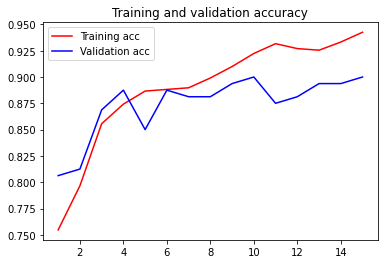

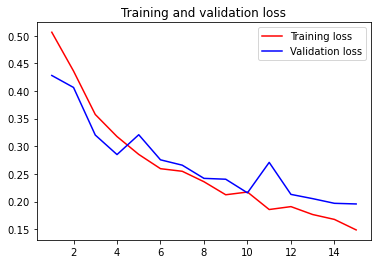

In [83]:
acc = history_mobv2_fine.history['accuracy']
val_acc = history_mobv2_fine.history['val_accuracy']
loss = history_mobv2_fine.history['loss']
val_loss = history_mobv2_fine.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

## Model Inference

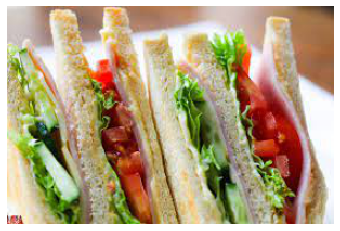

Result     :  [[0]]
Class Name :  sandwich



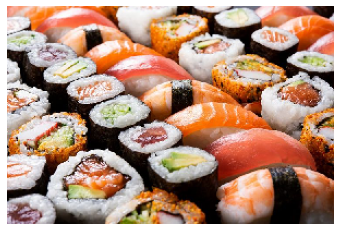

Result     :  [[1]]
Class Name :  sushi



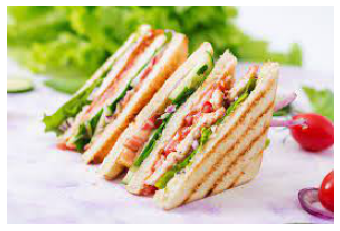

Result     :  [[0]]
Class Name :  sandwich



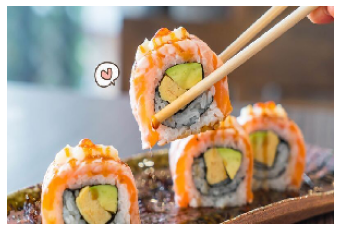

Result     :  [[1]]
Class Name :  sushi



In [85]:
img_paths = ['/Users/siaaldo/Documents/Hacktiv8/P2M2/sandwich2.jpg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/sushi.jpg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/download.jpg',
             'resep-sushi.width-800.jpegquality-80.jpg'
]

for filename in img_paths:
  plt.subplot(1,1,1)
  img = image.load_img(filename, target_size=IMG_SIZE)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)

  prediction = (model_mobv2.predict(img_batch) > 0.5).astype("int32")
  result_max_proba = prediction[0][0]
  result_class = class_names[result_max_proba]

  print('Result     : ', prediction)
  print('Class Name : ', result_class)
  print('')

# VGG16

## Data Preprocessing

In [86]:
preprocess_input_vgg = tf.keras.applications.vgg16.preprocess_input

In [87]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_vgg16 = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classifier_activation='sigmoid')

In [88]:
base_model_vgg16.trainable = False

In [89]:
len(base_model_vgg16.layers)

19

In [90]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [91]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model_vgg16(image_batch)
print(feature_batch.shape)

(32, 6, 9, 512)


In [92]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [93]:
prediction_layer = tf.keras.layers.Dense(1, 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

## Defining Model

In [94]:
inputs = tf.keras.Input(shape=(200, 300, 3))
x = preprocess_input_vgg(inputs)
x = data_augmentation(x)
x = base_model_vgg16(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model_vgg= tf.keras.Model(inputs, outputs)

In [95]:
base_learning_rate = 0.0001
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [96]:
model_vgg.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 200, 300, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 200, 300, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 200, 300, 3)       0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 200, 300, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 6, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0   

## Model Training

In [97]:
history_vgg = model_vgg.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, 
                                               restore_best_weights=True)
)

Epoch 1/10
21/21 [==============================] - 127s 6s/step - loss: 2.4668 - accuracy: 0.4720 - val_loss: 1.6914 - val_accuracy: 0.5312
Epoch 2/10
21/21 [==============================] - 133s 6s/step - loss: 2.2213 - accuracy: 0.5419 - val_loss: 1.6011 - val_accuracy: 0.5125
Epoch 3/10
21/21 [==============================] - 137s 7s/step - loss: 2.2165 - accuracy: 0.5062 - val_loss: 1.5271 - val_accuracy: 0.5188
Epoch 4/10
21/21 [==============================] - 149s 7s/step - loss: 2.3836 - accuracy: 0.5047 - val_loss: 1.4556 - val_accuracy: 0.5312


## Model Evalutaion

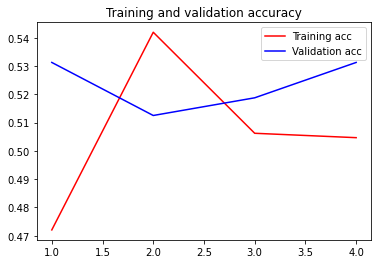

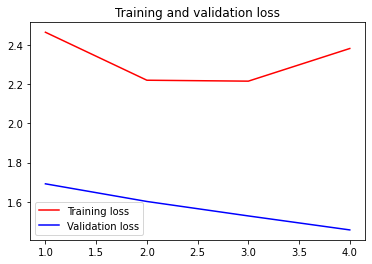

In [98]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

# FINE TUNE VGG16

In [99]:
base_model_vgg16.trainable = True

print("Number of layers in the base model: ", len(base_model_vgg16.layers))


Number of layers in the base model:  19


In [100]:
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_vgg16.layers[:fine_tune_at]:
  layer.trainable =  False

In [101]:
model_vgg.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [103]:
model_vgg.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 200, 300, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 200, 300, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 200, 300, 3)       0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 200, 300, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 6, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0   

In [104]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_vgg_fine = model_vgg.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_vgg.epoch[-1],
                         validation_data=val_ds,
                         callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, 
                                               restore_best_weights=True)
)

Epoch 4/110
21/21 [==============================] - 120s 6s/step - loss: 2.0769 - accuracy: 0.5326 - val_loss: 0.9374 - val_accuracy: 0.6938
Epoch 5/110
21/21 [==============================] - 143s 7s/step - loss: 1.3624 - accuracy: 0.6304 - val_loss: 0.7174 - val_accuracy: 0.7312
Epoch 6/110
21/21 [==============================] - 153s 7s/step - loss: 1.2716 - accuracy: 0.6599 - val_loss: 0.5763 - val_accuracy: 0.7875
Epoch 7/110
21/21 [==============================] - 155s 7s/step - loss: 1.1140 - accuracy: 0.6957 - val_loss: 0.6410 - val_accuracy: 0.7937
Epoch 8/110
21/21 [==============================] - 867s 43s/step - loss: 0.9388 - accuracy: 0.7438 - val_loss: 0.5135 - val_accuracy: 0.8125
Epoch 9/110
21/21 [==============================] - 114s 5s/step - loss: 0.8037 - accuracy: 0.7593 - val_loss: 0.4695 - val_accuracy: 0.8250
Epoch 10/110
21/21 [==============================] - 130s 6s/step - loss: 0.8905 - accuracy: 0.7593 - val_loss: 0.5009 - val_accuracy: 0.8188
Epoc

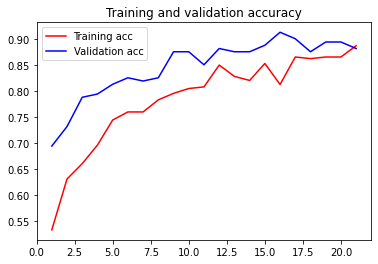

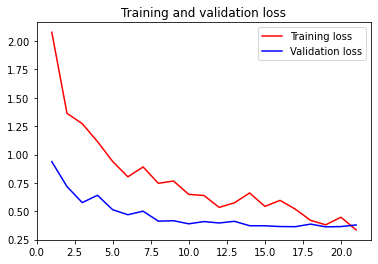

In [105]:
acc = history_vgg_fine.history['accuracy']
val_acc = history_vgg_fine.history['val_accuracy']
loss = history_vgg_fine.history['loss']
val_loss = history_vgg_fine.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

## Model Inference

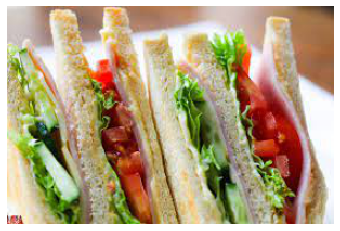

Result     :  [[0]]
Class Name :  sandwich



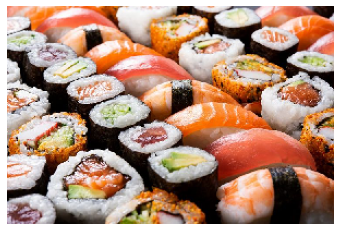

Result     :  [[1]]
Class Name :  sushi



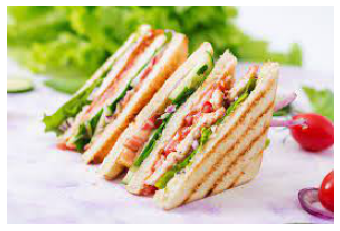

Result     :  [[0]]
Class Name :  sandwich



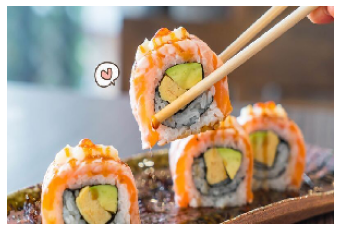

Result     :  [[1]]
Class Name :  sushi



In [107]:
img_paths = ['/Users/siaaldo/Documents/Hacktiv8/P2M2/sandwich2.jpg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/sushi.jpg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/download.jpg',
             'resep-sushi.width-800.jpegquality-80.jpg'
]

for filename in img_paths:
  plt.subplot(1,1,1)
  img = image.load_img(filename, target_size=IMG_SIZE)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)

  prediction = (model_vgg.predict(img_batch) > 0.5).astype("int32")
  result_max_proba = prediction[0][0]
  result_class = class_names[result_max_proba]

  print('Result     : ', prediction)
  print('Class Name : ', result_class)
  print('')

# Multi Label Classification Using MobileNetV2

## Data Preprocessing

In [132]:
batch_size = 32

#image pixel for uniform size each image
IMG_SIZE = (200, 300)

## Train & Test Data Split

In [160]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_folder,
  validation_split=0.2,
  labels='inferred',
  label_mode='categorical', #the secret behind it
  subset="training",
  seed=25,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 804 files belonging to 2 classes.
Using 644 files for training.


In [161]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_folder,
  validation_split=0.2,
  subset="validation", 
  seed=25,
  image_size=IMG_SIZE,
  label_mode='categorical', #the secret behind it
  batch_size=batch_size
)

Found 804 files belonging to 2 classes.
Using 160 files for validation.


In [162]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./225.)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(2, 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
inputs = tf.keras.Input(shape=(200, 300, 3))

(32, 7, 10, 1280)
(32, 1280)


## Defining model

In [163]:
x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model_multi = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
model_multi.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [164]:
model_multi.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 200, 300, 3)]     0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, 200, 300, 3)       0         
_________________________________________________________________
tf.math.subtract_8 (TFOpLamb (None, 200, 300, 3)       0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 200, 300, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 10, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1280)              0   

In [165]:
initial_epochs = 10

history = model_multi.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)

Epoch 1/10
21/21 [==============================] - 10s 418ms/step - loss: 0.7542 - accuracy: 0.5419 - val_loss: 0.6536 - val_accuracy: 0.6812
Epoch 2/10
21/21 [==============================] - 8s 374ms/step - loss: 0.7119 - accuracy: 0.6102 - val_loss: 0.6346 - val_accuracy: 0.6938
Epoch 3/10
21/21 [==============================] - 8s 362ms/step - loss: 0.6959 - accuracy: 0.6102 - val_loss: 0.6160 - val_accuracy: 0.7500
Epoch 4/10
21/21 [==============================] - 8s 379ms/step - loss: 0.6849 - accuracy: 0.6289 - val_loss: 0.5995 - val_accuracy: 0.7750
Epoch 5/10
21/21 [==============================] - 10s 481ms/step - loss: 0.6553 - accuracy: 0.6677 - val_loss: 0.5830 - val_accuracy: 0.7750
Epoch 6/10
21/21 [==============================] - 10s 474ms/step - loss: 0.6604 - accuracy: 0.6584 - val_loss: 0.5675 - val_accuracy: 0.7812
Epoch 7/10
21/21 [==============================] - 10s 454ms/step - loss: 0.6381 - accuracy: 0.7003 - val_loss: 0.5543 - val_accuracy: 0.8000
Ep

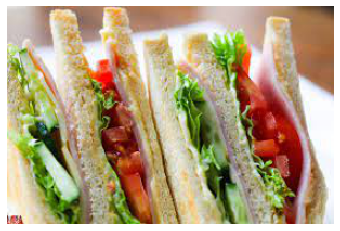

Result     :  [[0 0]]
Class Name : No Sandwich & No Sushi



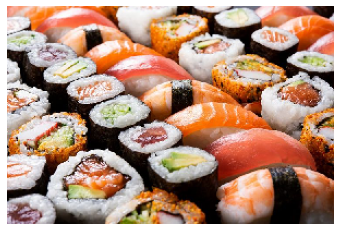

Result     :  [[0 1]]
Class Name : Only Sushi



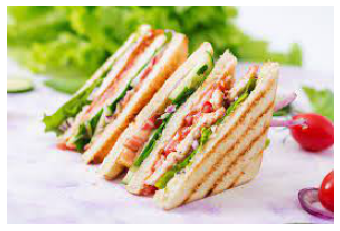

Result     :  [[0 0]]
Class Name : No Sandwich & No Sushi



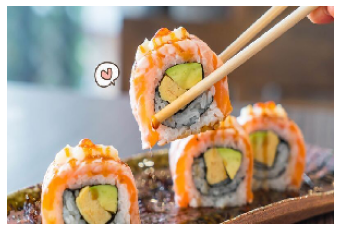

Result     :  [[0 0]]
Class Name : No Sandwich & No Sushi



In [166]:
img_paths = ['/Users/siaaldo/Documents/Hacktiv8/P2M2/sandwich2.jpg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/sushi.jpg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/download.jpg',
             'resep-sushi.width-800.jpegquality-80.jpg'
]

for filename in img_paths:
  plt.subplot(1,1,1)
  img = image.load_img(filename, target_size=IMG_SIZE)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)

  prediction = (model_multi.predict(img_batch) > 0.8).astype("int32")
  print('Result     : ', prediction)
  if prediction[0][0] == 1 and prediction[0][1] == 1:
    print(f'Class Name : Sandwich & Sushi')
  elif prediction[0][0] == 1 and prediction[0][1] == 0:
    print(f'Class Name : Only Sandwich')
  elif prediction[0][0] == 0 and prediction[0][1] == 1:
    print(f'Class Name : Only Sushi')
  elif prediction[0][0] ==  0 and prediction[0][1] == 0:
    print(f'Class Name : No Sandwich & No Sushi')

  print('')

# Fine Tuning Model

In [167]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [168]:
# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [169]:
model_multi.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [170]:
model_multi.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 200, 300, 3)]     0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, 200, 300, 3)       0         
_________________________________________________________________
tf.math.subtract_8 (TFOpLamb (None, 200, 300, 3)       0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 200, 300, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 10, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1280)              0   

In [171]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_multi.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks = tf.keras.callbacks.EarlyStopping(patience=5, 
                                               restore_best_weights=True)
)

Epoch 10/110
21/21 [==============================] - 12s 480ms/step - loss: 0.4948 - accuracy: 0.7671 - val_loss: 0.2969 - val_accuracy: 0.8750
Epoch 11/110
21/21 [==============================] - 10s 480ms/step - loss: 0.3510 - accuracy: 0.8540 - val_loss: 0.2975 - val_accuracy: 0.8562
Epoch 12/110
21/21 [==============================] - 11s 498ms/step - loss: 0.2599 - accuracy: 0.8944 - val_loss: 0.2419 - val_accuracy: 0.9000
Epoch 13/110
21/21 [==============================] - 10s 486ms/step - loss: 0.2030 - accuracy: 0.9146 - val_loss: 0.2246 - val_accuracy: 0.8875
Epoch 14/110
21/21 [==============================] - 12s 541ms/step - loss: 0.1740 - accuracy: 0.9363 - val_loss: 0.2471 - val_accuracy: 0.9062
Epoch 15/110
21/21 [==============================] - 12s 536ms/step - loss: 0.1578 - accuracy: 0.9348 - val_loss: 0.2195 - val_accuracy: 0.8938
Epoch 16/110
21/21 [==============================] - 12s 538ms/step - loss: 0.1189 - accuracy: 0.9503 - val_loss: 0.2988 - val_ac

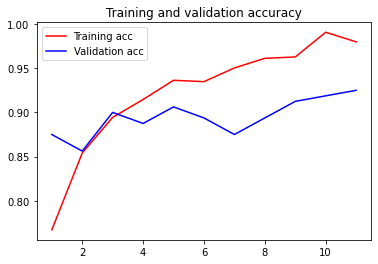

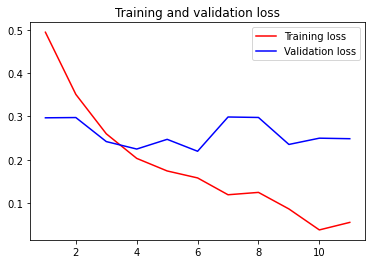

In [172]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

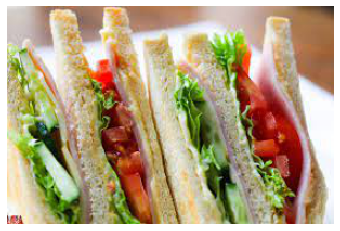

Result     :  [[1 0]]
Class Name : Only Sandwich



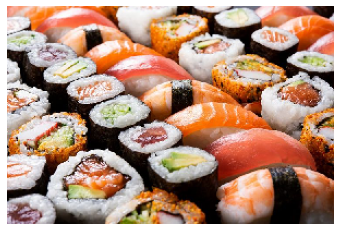

Result     :  [[0 1]]
Class Name : Only Sushi



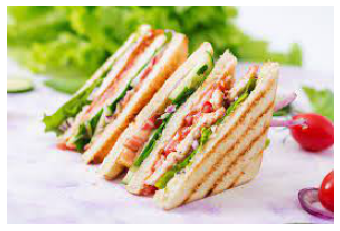

Result     :  [[1 0]]
Class Name : Only Sandwich



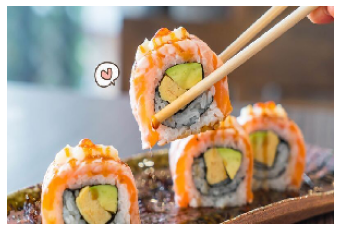

Result     :  [[0 1]]
Class Name : Only Sushi



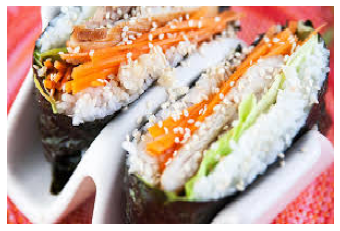

Result     :  [[0 1]]
Class Name : Only Sushi



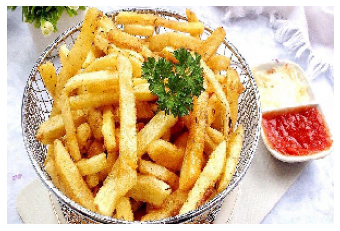

Result     :  [[0 0]]
Class Name : No Sandwich & No Sushi



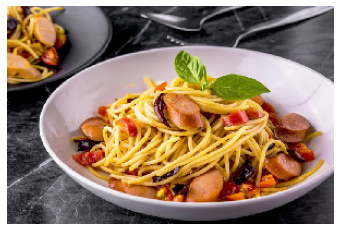

Result     :  [[0 1]]
Class Name : Only Sushi



In [175]:
img_paths = ['/Users/siaaldo/Documents/Hacktiv8/P2M2/sandwich2.jpg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/sushi.jpg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/download.jpg',
             'resep-sushi.width-800.jpegquality-80.jpg',
             'sushi sandwich.jpeg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/kentang.jpeg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/spaghetti.jpeg',
]

for filename in img_paths:
  plt.subplot(1,1,1)
  img = image.load_img(filename, target_size=IMG_SIZE)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)

  prediction = (model_multi.predict(img_batch) > 0.8).astype("int32")
  print('Result     : ', prediction)
  if prediction[0][0] == 1 and prediction[0][1] == 1:
    print(f'Class Name : Sandwich & Sushi')
  elif prediction[0][0] == 1 and prediction[0][1] == 0:
    print(f'Class Name : Only Sandwich')
  elif prediction[0][0] == 0 and prediction[0][1] == 1:
    print(f'Class Name : Only Sushi')
  elif prediction[0][0] ==  0 and prediction[0][1] == 0:
    print(f'Class Name : No Sandwich & No Sushi')

  print('')

In [174]:
model_multi.save('last_model.h5')